In [1]:
import wandb
import pandas as pd
import pickle
import seaborn as sns 
import functools
import operator 

In [2]:
def read_wandb_csv(loc):
    df = pd.read_csv(loc)
    df.param_config_id = df.param_config_id.astype('str')
    return df

id_df = read_wandb_csv("data/A_3_dropout_rate_test.csv")
id_df

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,ID,Group,...,test_f1_best_eval_loss,test_f1_best_f1,train_loss,train_p_max,train_p_var,train_st1_loss,train_st1_p_max,train_st2_loss,train_st2_p_max,vector_norms
0,26_S4_ID_14_MOD,running,-,ricu,"SWP4, modded",2024-01-14T10:01:05.000Z,511,NaN,wdyralqa,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000893,0.999107,0.001462,0.998539,"{""_type"":""histogram"",""bins"":[0.000009897533345..."
1,26_S4_ID_13_MOD,finished,-,ricu,"SWP4, modded",2024-01-14T09:53:47.000Z,415,NaN,qqeezlx7,NaN,...,NaN,NaN,NaN,NaN,NaN,0.002051,0.997952,0.002876,0.997129,"{""_type"":""histogram"",""bins"":[0.000005760275598..."
2,26_S4_ID_12_MOD,finished,-,ricu,"SWP4, modded",2024-01-14T09:44:49.000Z,514,NaN,qb8ul17p,NaN,...,NaN,NaN,NaN,NaN,NaN,0.001670,0.998331,0.002357,0.997646,"{""values"":[20,20,8,21,13,9,4,9,2,4,4,6,1,2,3,0..."
3,26_S4_ID_11_MOD,finished,-,ricu,"SWP4, modded",2024-01-14T09:30:52.000Z,812,NaN,6q21qjvn,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000297,0.999703,0.000561,0.999439,"{""values"":[10,4,14,16,20,10,7,14,5,9,5,2,1,1,2..."
4,26_S4_ID_10_MOD,finished,-,ricu,"SWP4, modded",2024-01-14T09:24:06.000Z,383,NaN,xo3sz49r,NaN,...,NaN,NaN,NaN,NaN,NaN,0.001859,0.998143,0.002705,0.997299,"{""_type"":""histogram"",""bins"":[0.000001291100033..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,26_S0_ID_04_MOD,finished,-,ricu,"SWP0, modded",2024-01-14T00:28:57.000Z,398,NaN,wm5hl0z6,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000630,0.999370,0.000966,0.999035,"{""bins"":[6.971422408241779e-7,0.00047044936218..."
119,26_S0_ID_03_MOD,finished,-,ricu,"SWP0, modded",2024-01-14T00:25:26.000Z,187,NaN,s7ju6dvh,NaN,...,NaN,NaN,NaN,NaN,NaN,0.002326,0.997677,0.008469,0.996804,"{""_type"":""histogram"",""bins"":[2.147785380657296..."
120,26_S0_ID_02_MOD,finished,-,ricu,"SWP0, modded",2024-01-14T00:16:57.000Z,486,NaN,fwlf2drp,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000236,0.999764,0.000384,0.999616,"{""bins"":[8.165423537320748e-7,0.00022629987506..."
121,26_S0_ID_01_MOD,finished,-,ricu,"SWP0, modded",2024-01-14T00:11:04.000Z,329,NaN,rsep1ht2,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000671,0.999329,0.001271,0.998752,"{""_type"":""histogram"",""bins"":[3.693585597375204..."


In [3]:
from tqdm import tqdm
run_ids = id_df["ID"]

api = wandb.Api()

all_dfs = []
metrics_train = ["train_st2_loss"]
metrics_eval = ["accuracy","eval_loss","eval_p_max"]
metrics_lr = ["learning_rate"]
index_keys = ["_step","epoch"]

# Add tqdm to the loop for progress bar
for run_id in tqdm(run_ids):
    run = api.run(f"ricu/fantastic-umbrella/{run_id}")
    
    # Fetch the history
    history_train = run.scan_history(keys=metrics_train+index_keys)
    df_run =  pd.DataFrame([row for row in history_train])
    
    history_eval = run.scan_history(keys=metrics_eval+index_keys)
    df_run = df_run.merge(pd.DataFrame([row for row in history_eval]), on=['_step', 'epoch'], how='outer')
    
    history_lr = run.scan_history(keys=metrics_lr+index_keys)
    df_run = df_run.merge(pd.DataFrame([row for row in history_lr]), on=['_step', 'epoch'], how='outer')
    df_run = df_run.sort_values(by="_step", ascending=True,ignore_index=True)
    # last_step_diff = df_run["_step"].iloc[-1] - df_run["_step"].iloc[-2]
    # first_step_diff = df_run["_step"].iloc[1] - df_run["_step"].iloc[0]
    # if last_step_diff != first_step_diff:
    #     df_run.at[df_run.index[-1], 'train_st2_loss'] = df_run['train_st2_loss'].iloc[-1] / last_step_diff
    df_run["learning_rate"] = df_run["learning_rate"].fillna(0)

    for key, value in run.config.items():
        df_run = df_run.assign(**{key: value})
    
    all_dfs.append(df_run)

df = pd.concat(all_dfs,axis=0,ignore_index=True)
df["mode"] = df["catch_dropout"].fillna(1).map({0: 'FUMBRELLA', 1: 'VANILLA'})
with open("data/A_3_dropout.pkl",'wb') as f:
    pickle.dump(df,f)

100%|██████████| 123/123 [05:17<00:00,  2.58s/it]


In [8]:
with open("data/A_3_dropout.pkl",'rb') as f:
    df = pickle.load(f)
df.head()

,train_st2_loss,_step,epoch,accuracy,eval_loss,eval_p_max,learning_rate,seed,beta1,beta2,...,num_warmup_steps,lr_scheduler_type,pad_to_max_length,model_name_or_path,warmup_steps_fraction,early_stopping_patience,ignore_mismatched_sizes,early_stopping_min_delta,per_device_eval_batch_size,per_device_train_batch_size
0,NaN,0,-1,0.453613,0.806656,0.662279,0.00003,3,0.9,0.999,...,80,linear,False,bert-base-uncased,0.1,40,False,0,128,32
1,0.821650,4,1,0.454590,0.804965,0.660702,0.00003,3,0.9,0.999,...,80,linear,False,bert-base-uncased,0.1,40,False,0,128,32
2,0.780583,8,3,0.454590,0.798809,0.654897,0.00003,3,0.9,0.999,...,80,linear,False,bert-base-uncased,0.1,40,False,0,128,32
3,0.775312,12,5,0.458496,0.788556,0.644111,0.00003,3,0.9,0.999,...,80,linear,False,bert-base-uncased,0.1,40,False,0,128,32
4,0.752005,16,7,0.459473,0.774892,0.627778,0.00003,3,0.9,0.999,...,80,linear,False,bert-base-uncased,0.1,40,False,0,128,32


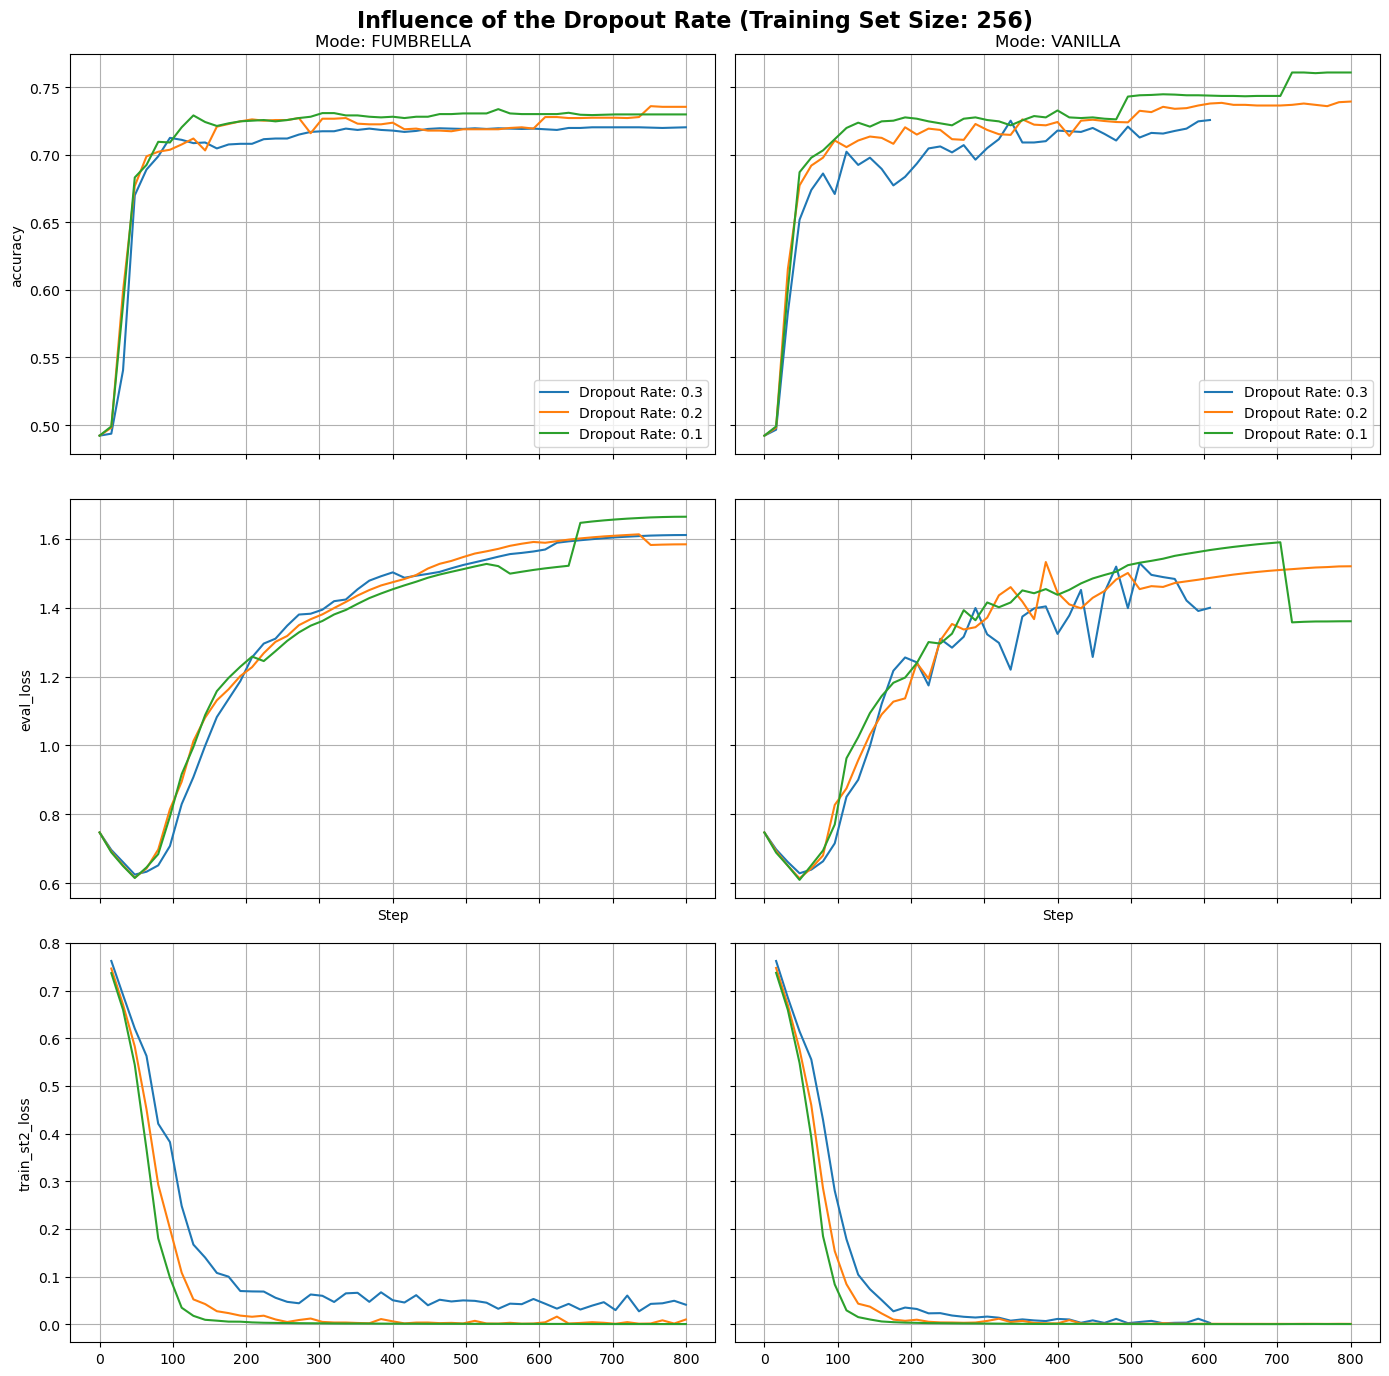

In [12]:
import matplotlib.pyplot as plt
selected_rows = functools.reduce(
    operator.and_,
    [
        df["training_size"] == 256
        # df["Tags"].str.contains('modded')
    ]  
    )
filtered_df = df.loc[selected_rows]

subplot_columns = sorted(df["mode"].unique())
subplot_rows = ['accuracy', 'eval_loss', 'train_st2_loss']

# Create a new figure
fig, axs = plt.subplots(
    len(subplot_rows),
    len(subplot_columns),
    sharex=True,
    sharey='row',
    figsize = (14,14)
    # figsize = (TEXTWIDTH,TEXTWIDTH)
    )

for idy, col_val in enumerate(subplot_columns):
    for idx, row_val in enumerate(subplot_rows):
        grouped_df = filtered_df.loc[df["mode"]==col_val].groupby(["insert_dropout","_step"])
        statistics = grouped_df[row_val].agg(['mean', 'median', 'std'])
        statistics = statistics.sort_index(level='insert_dropout', ascending=False)

        for dropout_rate in statistics.index.get_level_values('insert_dropout').unique():
            lr_stats = statistics.loc[dropout_rate]
            axs[idx,idy].plot(lr_stats.index, lr_stats["median"], label=f'Dropout Rate: {dropout_rate}')

        if idy == 0:
            axs[idx,idy].set_ylabel(row_val)
        if idx == 0:
            axs[idx,idy].set_title(f'Mode: {col_val}')
        if idx == len(subplot_columns) - 1:
            axs[idx,idy].set_xlabel('Step')

        axs[idx,idy].grid(True,which='major')
        axs[idx,idy].grid(True,which='minor')

        if idx == 0:
            axs[idx,idy].legend()


fig.suptitle('Influence of the Dropout Rate (Training Set Size: 256)', fontsize=16,weight='bold')
# Show the plot
plt.tight_layout()
plt.savefig('img/A_3_dropout.pdf', format='pdf')
plt.show()